In [1]:
from typing import Dict, Any, Tuple, List

import torch
import torch.nn as nn
from configs import config
from torch.nn import functional as F
from model import SparseSegNet, SSCHead, MyModel, SparseSegNet2DPASS
import MinkowskiEngine as Me
from semantic_kitti_dataset import SemanticKITTIDataset, Merge
from tqdm import tqdm
import numpy as np
import time
from structures import collect
from evaluation import iouEval
import k3d
import numpy as np
from utils import plot_3d_voxels, plot_2d_input, plot_bev, plot_3d_pointcloud
from model import VoxelPooling
device = torch.device("cuda:0")

shapes = {"256": torch.Size([1, 1, 256, 256, 32]), "128": torch.Size([1, 1, 128, 128, 16]), "64": torch.Size([1, 1, 64, 64, 8])}

%load_ext autoreload
%autoreload 2

## Dataloader

In [2]:
config.GENERAL.NUM_SAMPLES_OVERFIT = 1
config.GENERAL.OVERFIT = True
config.TRAIN.AUGMENT = False
config.TRAIN.NOISE_LEVEL = 0.0
config.TRAIN.NUM_WORKERS = 0
config.TRAIN.BATCH_SIZE = 1

train_dataset = SemanticKITTIDataset("train",do_overfit=config.GENERAL.OVERFIT, num_samples_overfit=config.GENERAL.NUM_SAMPLES_OVERFIT, augment=config.TRAIN.AUGMENT)
train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN.BATCH_SIZE,
        collate_fn=Merge,
        num_workers=config.TRAIN.NUM_WORKERS,
        pin_memory=True,
        shuffle=False,
        drop_last=True,
        worker_init_fn=lambda x: np.random.seed(x + int(time.time()))
    )
print(len(train_data_loader))

1


In [3]:
batch = next(iter(train_data_loader))
_, complet_inputs, _, _ = batch


## Complet Model

In [4]:
model = MyModel().cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load seg pretrained
seg_labelweights = torch.Tensor(train_dataset.seg_labelweights).cuda()
compl_labelweights = torch.Tensor(train_dataset.compl_labelweights).cuda()

# config.SEGMENTATION.CHECKPOINT = "/usr/src/app/semantic-scene-completion/experiments/008/modelFULL-9.pth"
# model_seg_checkpoint = MyModel().cuda()
# model_seg_checkpoint.load_state_dict(torch.load(config.SEGMENTATION.CHECKPOINT))
# model.seg_model.load_state_dict(model_seg_checkpoint.seg_model.state_dict())
# del model_seg_checkpoint

# model.seg_model.requires_grad = False

print("Total params: ", pytorch_total_params)
model.eval()

with torch.no_grad():
    start = time.time()
    results, losses, _ = model(complet_inputs, seg_weights=seg_labelweights, compl_weights=compl_labelweights)
    end = time.time()
    print("time: ",end-start)
    print(results.keys())
    print(losses)



2DPASS config:  {'format_version': 1, 'model_params': {'model_architecture': 'arch_2dpass', 'input_dims': 4, 'spatial_shape': [1000, 1000, 60], 'scale_list': [2, 4, 8, 16], 'hiden_size': 64, 'num_classes': 20, 'backbone_2d': 'resnet34', 'pretrained2d': False}, 'dataset_params': {'training_size': 19132, 'dataset_type': 'point_image_dataset_semkitti', 'pc_dataset_type': 'SemanticKITTI', 'collate_type': 'collate_fn_default', 'ignore_label': 0, 'label_mapping': '/usr/src/app/semantic-scene-completion/thirdparty/2DPASS/config/label_mapping/semantic-kitti.yaml', 'bottom_crop': [480, 320], 'color_jitter': [0.4, 0.4, 0.4], 'flip2d': 0.5, 'image_normalizer': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]], 'max_volume_space': [50, 50, 2], 'min_volume_space': [-50, -50, -4], 'seg_labelweights': [0, 55437630, 320797, 541736, 2578735, 3274484, 552662, 184064, 78858, 240942562, 17294618, 170599734, 6369672, 230413074, 101130274, 476491114, 9833174, 129609852, 4506626, 1168181], 'train_data_loader': 

/usr/src/app/semantic-scene-completion/thirdparty/2DPASS/network/spvcnn.py:195: RuntimeWarning: divide by zero encountered in divide
  seg_labelweights = torch.Tensor(np.power(np.amax(seg_labelweights) / seg_labelweights, 1 / 3.0))
/usr/src/app/semantic-scene-completion/thirdparty/2DPASS/network/arch_2dpass.py:56: RuntimeWarning: divide by zero encountered in divide
  seg_labelweights = torch.Tensor(np.power(np.amax(seg_labelweights) / seg_labelweights, 1 / 3.0))


loading pre-trained segmentation model...
2DPASS model
num_input_features: 256
Total params:  11063498


/usr/src/app/semantic-scene-completion/thirdparty/2DPASS/network/spvcnn.py:47: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  coors = coors[:, 1:] // scale
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/MinkowskiSparseTensor.py:295: UserWarning: coordinates implicitly converted to torch.IntTensor. To remove this warning, use `.int()` to convert the coords into an torch.IntTensor
  warnings.warn(


seg_out torch.Size([124668, 19])
seg_feat torch.Size([124668, 256])
time:  0.586111307144165
dict_keys(['pc_seg', 'occupancy_64', 'semantic_64'])
{'pc_seg': tensor(0.1565, device='cuda:0'), 'occupancy_64': tensor(0.7549, device='cuda:0'), 'semantic_64': tensor(0.0561, device='cuda:0')}


/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/MinkowskiSparseTensor.py:537: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  coords = coords // tensor_stride


In [5]:
print(losses['pc_seg'])


tensor(0.1565, device='cuda:0')


## Visualize predictions from pretrained segmentation model

torch.Size([124668, 19])
torch.Size([124668])
torch.Size([124668, 3])
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18]


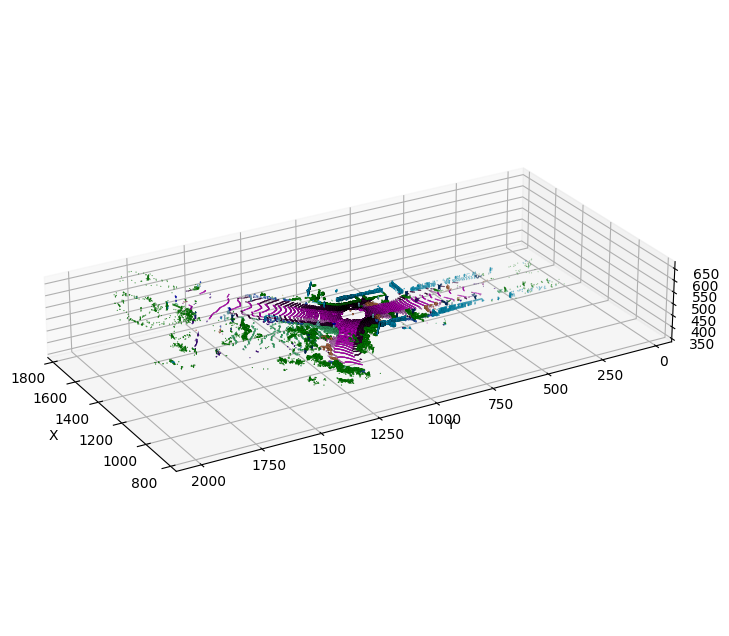

In [6]:
pc_seg = results['pc_seg']
print(pc_seg.shape)
pc_seg_pred = F.softmax(pc_seg, dim=1)
pc_seg_pred = torch.argmax(pc_seg_pred, dim=1)
print(pc_seg_pred.shape)

seg_coords = collect(complet_inputs, "seg_coords")[:,1:]
print(seg_coords.shape)

coords_np = seg_coords.detach().cpu().numpy()
plot_3d_pointcloud(seg_coords, pc_seg_pred)

# # Voxelize
# print("\n")
# print(torch.unique(complet_invoxel_features[:, :, -2]))
# voxelpool = VoxelPooling()
# voxelpool.pooling_mode = 'max'
# pc_seg_pred_vox = voxelpool(invoxel_xyz=complet_invoxel_features[:, :, :-1],
#                      invoxel_map=complet_invoxel_features[:, :, 3].long(),
#                      src_feat=pc_seg_pred.unsqueeze(1),
#                      voxel_center=voxel_centers).transpose(0,1)
# print("pc_seg_pred_vox: ", pc_seg_pred_vox.shape)
# print(torch.unique(pc_seg_pred_vox))

# coords = collect(complet_inputs, "complet_coords").cpu().numpy()[0,:,1:]
# print(coords.shape)

# coords_np = coords.astype(int)
# print(coords_np.shape)
# voxels = np.zeros((256,256,32))
# voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=(np.uint8(pc_seg_pred_vox.detach().cpu().numpy())+1)
# plot_3d_voxels(voxels, "256", input=False)

    

In [ ]:
seg_feat = results['seg_feat']
print(seg_feat.shape)
pc_seg = seg_feat[:,:19]
print(pc_seg.shape)
pc_seg_pred = F.softmax(pc_seg, dim=1)
pc_seg_pred = torch.argmax(pc_seg_pred, dim=1)
print(pc_seg_pred.shape)


coords = collect(complet_inputs, "complet_coords").cpu().numpy()[0,:,1:]
print(coords.shape)

coords_np = coords.astype(int)
print(coords_np.shape)
voxels = np.zeros((256,256,32))
voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=(np.uint8(pc_seg_pred_vox.detach().cpu().numpy())+1)
plot_3d_voxels(voxels, "256", input=False)

In [ ]:

classes_colors = [
    [245, 150, 100],
    [245, 230, 100],
    [150, 60, 30],
    [180, 30, 80],
    [255, 0, 0],
    [30, 30, 255],
    [200, 40, 255],
    [90, 30, 150],
    [255, 0, 255],
    [255, 150, 255],
    [75, 0, 75],
    [75, 0, 175],
    [0, 200, 255],
    [50, 120, 255],
    [0, 175, 0],
    [0, 60, 135],
    [80, 240, 150],
    [150, 240, 255],
    [0, 0, 255],
    [255, 255, 50]]
print(len(classes_colors))
classes_cmap = []
for rgb in (np.uint8(classes_colors)):
    hex_str = rgb_to_hex(rgb)
    hex_int = int(hex_str, 16)
    new_int = hex_int + 0x200
    classes_cmap.append(new_int)

classes_cmap = np.array(classes_cmap)

import k3d
pc_seg = results['pc_seg']
pc_seg_pred = F.softmax(pc_seg, dim=1)
pc_seg_pred = torch.argmax(pc_seg_pred, dim=1)
seg_coords = collect(complet_inputs, "seg_coords")[:,1:]

# plot_3d_pointcloud(seg_coords[0],seg_labels[0])
seg_labels_np = np.uint32(pc_seg_pred.detach().cpu().numpy())
seg_coords_np = np.float32(seg_coords.detach().cpu().numpy())
print(seg_coords_np.shape)
print(seg_labels_np.shape)
seg_coords_np = seg_coords_np[seg_labels_np<100]
seg_labels_np = seg_labels_np[seg_labels_np<100]+1
print(seg_coords_np.shape)
print(seg_labels_np.shape)
print(np.unique(seg_labels_np))
plot = k3d.plot(camera_auto_fit=True)
colors = classes_cmap[np.uint8(seg_labels_np)]
plt_points = k3d.points(seg_coords_np, attribute=np.uint32(seg_labels_np),point_size=1,shader="dot",colors=colors)
plot += plt_points
plot.display()

## Visualize data

In [ ]:
x = np.random.uniform(size=1000) < 0.1
print(np.sum(x))

In [ ]:
batch = next(iter(train_data_loader))
_, complet_inputs, _, _ = batch
seg_coords = collect(complet_inputs, "seg_coords")
# print(torch.unique(seg_coords[:,0]))
# print(torch.unique(seg_coords[:,1]))
# print(torch.unique(seg_coords[:,2]))
# print(torch.unique(seg_coords[:,3]))

seg_labels = collect(complet_inputs, "seg_labels")
seg_features = collect(complet_inputs, "seg_features")
print(seg_coords.shape)
print(seg_labels.shape)
print(seg_features.shape)

In [ ]:
level = "256"
input2d = collect(complet_inputs, "input2d")
bev_labels = collect(complet_inputs, "bev_labels")

gt_labels = collect(complet_inputs, "complet_labels_{}".format(level))
gt_labels = np.uint32(gt_labels.detach().cpu().numpy())
invalid = gt_labels==255
coords = collect(complet_inputs, "complet_coords").squeeze()
complet_features = collect(complet_inputs, "complet_features")
print(complet_features.shape)
print(coords.shape)


coords_np = coords[:,:].detach().cpu().numpy()
coords_np = coords_np.astype(int)
voxels = np.zeros((1,256,256,32))
# voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2]]=np.int32(complet_features.detach().cpu().numpy()[0]*10.0)
voxels[coords_np[:,0],coords_np[:,1],coords_np[:,2],coords_np[:,3]]=(np.uint8(complet_features[0].detach().cpu().numpy()*126.0)+1.0)
plot_3d_voxels(gt_labels[0], level)
plot_3d_voxels(voxels[0], level, input=True)
# plot_2d_input(input2d[0])
print("unique: ", torch.unique(bev_labels))

plot_bev(bev_labels[0])
# plot_3d_voxels(gt_labels[1], level)
# plot_3d_voxels(voxels[1], level,input=True)


In [17]:
import k3d


# plot_3d_pointcloud(seg_coords[0],seg_labels[0])

seg_labels_np = np.uint32(seg_labels.detach().cpu().numpy())
seg_coords_np = np.float32(seg_coords.detach().cpu().numpy())
seg_coords_np = seg_coords_np[:,1:]
seg_coords_np = seg_coords_np[seg_labels_np<100]
seg_labels_np = seg_labels_np[seg_labels_np<100]+1
print(seg_coords_np.shape)
print(seg_labels_np.shape)
print(np.unique(seg_labels_np))
plot = k3d.plot(camera_auto_fit=True)
plt_points = k3d.points(seg_coords_np, attribute=seg_labels_np,point_size=1,shader="dot",cmap=color_map)
plot += plt_points
plot.display()


(95801, 3)
(95801,)
[ 1  8  9 10 11 13 14 15 16 17 18 19]


Output()

## 2D UNet model